# Example of fragile attack on Saliency Map
* TopK attack
* Mass center attack
* Manipulate attack

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
pip install -r requirements.txt

# Import dependences

In [0]:
import os
import time
import math
import glob
import random
import argparse
import numpy as np
from PIL import Image
import scipy.stats as stats
import scipy.spatial as spatial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import dill
from robustness.datasets import ImageNet
from robustness.model_utils import make_and_restore_model

In [0]:
def convert_relu_to_softplus(model):
  for child_name, child in model.named_children():
      if isinstance(child, nn.ReLU):
          setattr(model, child_name, nn.Softplus())
      else:
          convert_relu_to_softplus(child)
  return model

# Hyper Params

In [0]:
# the path of targeted model
model_path = None

# define top K
top_K = 1000

# max iter
max_iter = 50

# max perturbation
max_epsilon = 8.0
eps = max_epsilon / 255.0

# attack method
method = "topK"

# Load model and data

In [13]:
ds = ImageNet('/path/to/imagenet')

if model_path is None:
  model, _, = make_and_restore_model(arch='resnet50', dataset=ds,
              resume_path=None, pytorch_pretrained=True)
  softplus_model, _, = make_and_restore_model(arch='resnet50', dataset=ds,
              resume_path=None, pytorch_pretrained=True)
else:
  model, _, = make_and_restore_model(arch='resnet50', dataset=ds,
             resume_path=model_path, pytorch_pretrained=False)
  softplus_model, _, = make_and_restore_model(arch='resnet50', dataset=ds,
              resume_path=model_path, pytorch_pretrained=False)

vgg = model.eval().cuda()
vgg_softplus = convert_relu_to_softplus(softplus_model).eval().cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [16]:
data_path = 'data/'
image_path = 'data/images'
cls_label = open(os.path.join(data_path,'labels.txt'))
cls_label = cls_label.readlines()
print(len(cls_label))

10


# Attack and Evaluate

In [0]:
label = 65
image_path = 'data/images/ILSVRC2012_val_00000001.JPEG'

image = Image.open(image_path).convert('RGB')
image = image.resize((224, 224), Image.ANTIALIAS)
image = np.array(image) / 255.0

In [0]:
# generate a target map of another image
if method == "manipulate":
  name = 'data/images/ILSVRC2012_val_00000002.JPEG'
  label = 970

  image = Image.open(name).convert('RGB')
  image = image.resize((224, 224), Image.ANTIALIAS)
  image = np.array(image) / 255.0

  # transfer Image into tensor, with shape NxCxHxW
  inputs = torch.from_numpy(image.transpose((2,0,1)))
  inputs = inputs.unsqueeze(0).float().requires_grad_(True).cuda()

  # get the saliency map using softplus model
  logit,_ = vgg_softplus(inputs)
  one_hot_output = torch.FloatTensor(1, logit.size()[-1]).zero_().cuda()
  one_hot_output[0][label] = 1
  target_map = torch.autograd.grad(torch.sum(logit[0]*one_hot_output), inputs, create_graph=True)[0] * inputs
  target_map = target_map.squeeze().detach()

  # combine color channel; normalized into (0,1) and scale by image size; flatten saliency map into 1D 
  normalized_target_map = torch.sum(torch.abs(target_map),0)
  normalized_target_map = 224*224*normalized_target_map/torch.sum(normalized_target_map)


'''
original result on softplus model
'''
# transfer Image into tensor, with shape NxCxHxW
inputs = torch.from_numpy(image.transpose((2,0,1)))
inputs = inputs.unsqueeze(0).float().requires_grad_(True).cuda()

# get the saliency map using softplus model
logit,_ = vgg_softplus(inputs)
original_logit,_ = vgg_softplus(inputs)
one_hot_output = torch.FloatTensor(1, logit.size()[-1]).zero_().cuda()
one_hot_output[0][label] = 1
original_saliency = torch.autograd.grad(torch.sum(logit[0]*one_hot_output), inputs, create_graph=True)[0] * inputs
original_saliency = original_saliency.squeeze().detach()

# combine color channel; normalized into (0,1) and scale by image size; flatten saliency map into 1D 
normalized_original_saliency = torch.sum(torch.abs(original_saliency),0)
normalized_original_saliency = 224*224*normalized_original_saliency/torch.sum(normalized_original_saliency)
normalized_original_saliency_flatten = normalized_original_saliency.flatten()

# get the mass center of original saliency map
y_mesh, x_mesh = np.meshgrid(np.arange(224),np.arange(224))
y_mesh, x_mesh = torch.Tensor(y_mesh).cuda(), torch.Tensor(x_mesh).cuda()
mass_center = [int(torch.sum(normalized_original_saliency*x_mesh)/(224*224)), int(torch.sum(normalized_original_saliency*y_mesh)/(224*224))]


'''
attack
'''
adv_image = inputs.clone()
best_adv_image = inputs.clone()
for i in range(max_iter):
  adv_image = adv_image.clone().detach().requires_grad_(True)

  # get the saliency map of current adversarial image
  logit,_ = vgg_softplus(adv_image)
  one_hot_output = torch.FloatTensor(1, logit.size()[-1]).zero_().cuda()
  one_hot_output[0][label] = 1
  saliency = torch.autograd.grad(torch.sum(logit[0]*one_hot_output), adv_image, create_graph=True)[0] * adv_image
  saliency = saliency.squeeze()

  # normalize the saliency map
  saliency = torch.sum(torch.abs(saliency),0)
  saliency = 224*224*saliency/torch.sum(saliency)
  saliency_flatten = saliency.flatten()

  # find the gradient direction
  if method == "topK":
    mask = torch.zeros(224*224).cuda()
    mask[torch.argsort(saliency.view(-1))[-top_K:]] = 1
    topK_loss = -torch.sum(saliency_flatten*mask)
    topK_direction = torch.autograd.grad(topK_loss, adv_image)[0]
    grad_sign = topK_direction.sign()
  elif method == "mass_center":
    mass_center_perturbed = [torch.sum(saliency*x_mesh)/(224*224), torch.sum(saliency*y_mesh)/(224*224)]
    mass_center_loss = ((mass_center[0]-mass_center_perturbed[0])**2 + (mass_center[1]-mass_center_perturbed[1])**2)
    mass_center_direction = torch.autograd.grad(mass_center_loss, adv_image)[0]
    grad_sign = mass_center_direction.sign()
  elif method == "manipulate":
    loss_expl = F.mse_loss(saliency, normalized_target_map)
    loss_output = F.mse_loss(original_logit, logit)
    total_loss = 1e11*loss_expl + 1e6*loss_output
    grad_sign = - torch.autograd.grad(total_loss, adv_image)[0].sign()
  else:
    grad_sign = torch.randn(adv_image.shape).cuda().sign()

  # apply perturbation
  adv_image = inputs + torch.clamp(adv_image+0.005*grad_sign-inputs, -eps, eps)
  adv_image = torch.clamp(adv_image, 0, 1)

  # evaluate each adv_image on given metric, save the best adv_image
  if vgg(inputs)[0].max(1)[-1] == vgg(adv_image)[0].max(1)[-1]:
      best_adv_image = adv_image.clone()

# Visualization

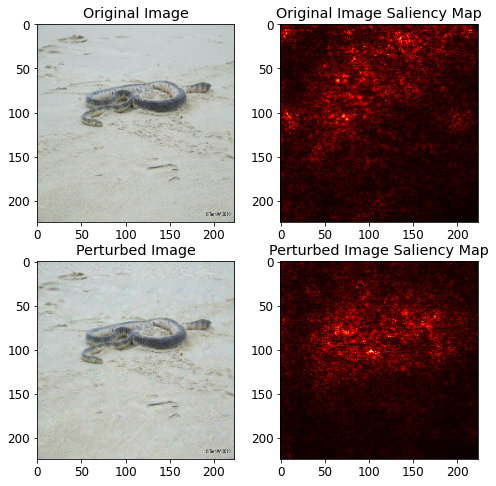

In [20]:
# for visual comparison
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.figsize"] = 8,8
plt.rc("text",usetex=False)
plt.rc("font",family = "sans-serif",size = 12)

inputs = inputs.requires_grad_(True)
logit,_ = vgg(inputs)
one_hot_output = torch.FloatTensor(1, logit.size()[-1]).zero_().cuda()
one_hot_output[0][label] = 1
gradient = torch.autograd.grad(torch.sum(logit*one_hot_output), inputs)[0] * inputs
gradient = gradient.squeeze().detach().cpu().numpy()

saliency = np.sum(np.abs(gradient),0)
original_saliency = 224*224*saliency/np.sum(saliency)
plt.subplot(2,2,1)
plt.title("Original Image")
plt.imshow(inputs.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.subplot(2,2,2)
plt.title("Original Image Saliency Map")
plt.imshow(original_saliency,cmap="hot")

adv_image = adv_image.requires_grad_(True)
logit,_ = vgg(adv_image)
one_hot_output = torch.FloatTensor(1, logit.size()[-1]).zero_().cuda()
one_hot_output[0][label] = 1

gradient = torch.autograd.grad(torch.sum(logit*one_hot_output), adv_image)[0] * adv_image
gradient = gradient.squeeze().detach().cpu().numpy()

saliency = np.sum(np.abs(gradient),0)
perturbed_saliency = 224*224*saliency/np.sum(saliency)
plt.subplot(2,2,3)
plt.title("Perturbed Image")
plt.imshow(adv_image.squeeze().detach().permute(1,2,0).cpu().numpy())
plt.subplot(2,2,4)
plt.title("Perturbed Image Saliency Map")
plt.imshow(perturbed_saliency,cmap="hot")